In [1]:
import pandas as pd
import plotly.express as px
from IPython.display import Image, display
import scipy.stats as stats
import requests
import json
from matplotlib import pyplot as plt

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

# Import the API key
from api_key import geoapify_key

In [2]:
# import clean data
clean_fraud_df = pd.read_csv("../Resources/clean_data.csv")

In [4]:
# Create a DataFrame grouped by states showing the count of frauds per state and adding % column
fraud_df = clean_fraud_df[clean_fraud_df["is_fraud"]==1]
total_fraud = fraud_df["trans_num"].nunique()
state_fraud = pd.DataFrame(fraud_df.groupby("state")["trans_num"].nunique()).reset_index()
state_fraud["percent"] = round(state_fraud["trans_num"] / total_fraud * 100,2)

In [5]:
# Complete the DataFrame with the States with 0 fraud transactions
states = clean_fraud_df["state"].unique()

for state in states:
    if state not in state_fraud["state"].values:
        state_fraud.loc[len(state_fraud)+1,"state"]=state
        state_fraud.loc[len(state_fraud),"trans_num"]=0
        state_fraud.loc[len(state_fraud),"percent"]=0

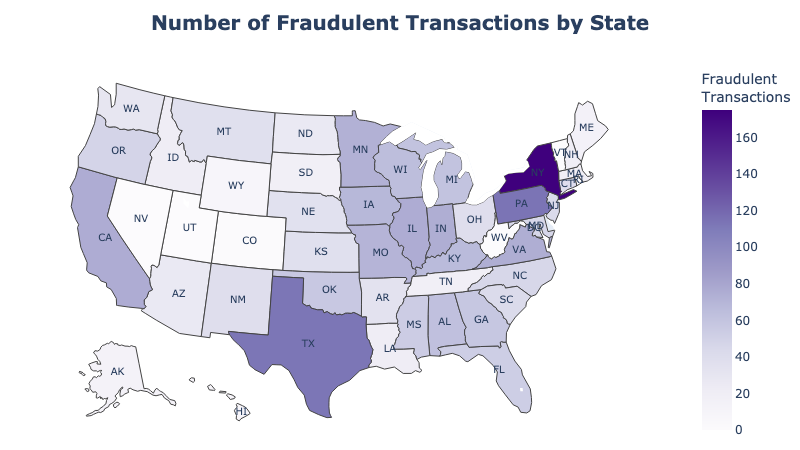

In [6]:
# Create a Choropleth map to show the amount of fraudulent transactions by state
map = px.choropleth(state_fraud,
                    locations= state_fraud["state"],
                    locationmode= "USA-states",
                    color= state_fraud["trans_num"],
                    scope= "usa",
                    color_continuous_scale= "purples",
                    labels={"trans_num": "Fraudulent<br>Transactions"},
                    title= "<b>Number of Fraudulent Transactions by State",
                    hover_data=["percent"],
                    width=800,
                    height=450          
)
map.add_scattergeo(locations=state_fraud["state"],
                   locationmode="USA-states", 
                   text=state_fraud["state"],
                   mode='text',
                   hoverinfo="skip",
                   textfont_size=10
)
map.update_layout(title_font_size=20,
                  title_x=0.5,
                  margin = dict(l=0,
                                r=0,
                                b=10,
                                t=60,
                                autoexpand=True
                  )
)
map.write_image("Images/daniel-1.png")
display(Image('Images/daniel-1.png'))

In [7]:
# Chi-square analysis
expected = total_fraud/state_fraud["state"].nunique()
chi_square_db = pd.DataFrame({"state":state_fraud["state"], "trans_num":state_fraud["trans_num"], "expected":expected})
stats.chisquare(chi_square_db["trans_num"], chi_square_db["expected"])

Power_divergenceResult(statistic=1317.773892773893, pvalue=1.0150802441617908e-243)

In [8]:
# Create a DataFrame grouped by states showing the total number of transactions per state
state_transaction = pd.DataFrame(clean_fraud_df.groupby("state")["trans_num"].nunique()).reset_index()

In [9]:
# Merge the State transaction and the State fraud DataFrames 
merge_fraud = pd.merge(state_transaction, state_fraud,on="state", how="left")

merge_fraud.rename(columns={"trans_num_x": "total_trans",
    "trans_num_y": "fraud_trans"}, inplace=True)
merge_fraud["percent"]=round(merge_fraud["fraud_trans"]/merge_fraud["total_trans"]*100,2)

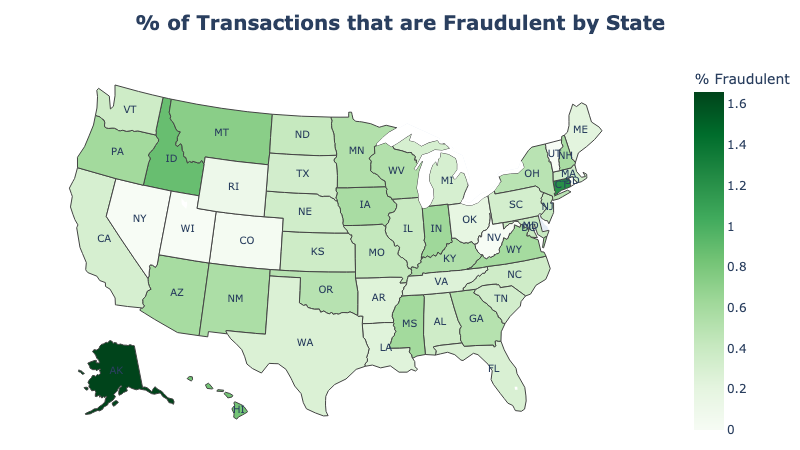

In [10]:
# Create a second choropleth map to show the % of transactions that are fraudulent by State
map2 = px.choropleth(merge_fraud,
                    locations= merge_fraud["state"],
                    locationmode= "USA-states",
                    color= merge_fraud["percent"],
                    scope= "usa",
                    color_continuous_scale= "greens",
                    labels={"percent": "% Fraudulent"},
                    title= "<b>% of Transactions that are Fraudulent by State",
                    width=800,
                    height=450          
)
map2.add_scattergeo(locations=merge_fraud["state"],
                   locationmode="USA-states", 
                   text=state_fraud["state"],
                   mode='text',
                   hoverinfo="skip",
                   textfont_size=10
)
map2.update_layout(title_font_size=20,
                  title_x=0.5,
                  margin = dict(l=0,
                                r=0,
                                b=10,
                                t=60,
                                autoexpand=True
                  )
)
map2.write_image("Images/daniel-3.png")
display(Image('Images/daniel-3.png'))

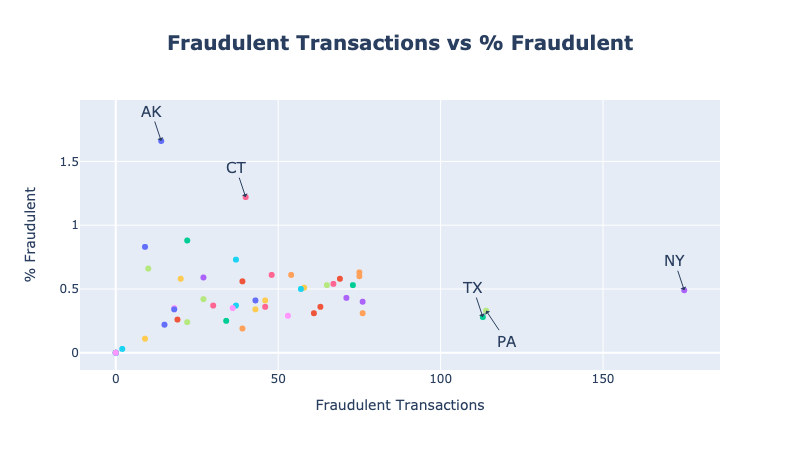

In [11]:
# Create a Scatterplot to show the comparison between the results of both maps
scatter = px.scatter(x= merge_fraud["fraud_trans"],
                  y= merge_fraud["percent"],
                  color= merge_fraud["state"],
                  labels={"x": "Fraudulent Transactions", "y" : "% Fraudulent", "color": "State"},
                  title= "<b>Fraudulent Transactions vs % Fraudulent",
                  width=800,
                  height=450          
)
scatter.update_layout(title_font_size=20,
                  title_x=0.5
                  )
marker_indices = [0, 6, 33,42]
for i in marker_indices:
    scatter.add_annotation(x=merge_fraud["fraud_trans"][i],
                           y=merge_fraud["percent"][i],
                           text=merge_fraud["state"][i],
                           showarrow= True,
                           arrowhead=1,
                           font=dict(size=15))
scatter.add_annotation(x=merge_fraud["fraud_trans"][37],
                           y=merge_fraud["percent"][37],
                           text=merge_fraud["state"][37],
                           showarrow= True,
                           arrowhead=1,
                           font=dict(size=15),
                           ay=30,
                           ax=20)
scatter.update_traces(showlegend=False)
scatter.write_image("Images/daniel-4.png")
display(Image('Images/daniel-4.png'))


In [224]:
# Iterate through the hotel_df DataFrame
for index, row in fraud_df.iterrows():
    
    # Get Lat and Lon from the data frame
    Lat = fraud_df.loc[index,"merch_lat"]
    Lon = fraud_df.loc[index,"merch_long"]
    
    # Add filter and bias parameters
    params = {"apiKey": geoapify_key,
              "lat": Lat,
              "lon": Lon
    }
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/reverse?"

    # Make and API request using the params dictionaty
    merch_info = requests.get(base_url, params=params).json()

    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        fraud_df.loc[index, "merch_country"] = merch_info["features"][0]["properties"]["country"]
        fraud_df.loc[index, "merch_state"] = merch_info["features"][0]["properties"]["state"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        fraud_df.loc[index, "merch_country"] = "No Country found"
        fraud_df.loc[index, "merch_state"] = "No State found"

fraud_df.to_csv("../Resources/fraud_test_merchant.csv")

In [12]:
# import merchant csv.
fraud_merchant_df = pd.read_csv("../Resources/fraud_test_merchant.csv")

In [14]:
# Remove rows with no merchant State.
clean_fraud_merchant_df= fraud_merchant_df[fraud_merchant_df["merch_state"]!="No State found"]

In [15]:
# Change the merchant state name to code.
state_codes = {"Alabama":"AL", "Alaska":"AK", "Arizona":"AZ", "Arkansas":"AR",
               "California":"CA", "Colorado":"CO", "Connecticut":"CT",
               "Delaware":"DE", "Florida":"FL", "Georgia":"GA", "Hawaii":"HI",
               "Idaho":"ID", "Illinois":"IL", "Indiana":"IN", "Iowa":"IA",
               "Kansas":"KS", "Kentucky":"KY", "Louisiana":"LA", "Maine":"ME",
               "Maryland":"MD", "Massachusetts":"MA", "Michigan":"MI",
               "Minnesota":"MN", "Mississippi":"MS","Missouri":"MO",
               "Montana":"MT", "Nebraska":"NE", "New Hampshire":"NH",
               "New Jersey":"NJ", "New Mexico":"NM", "New York":"NY",
               "North Carolina":"NC", "North Dakota":"ND", "Ohio":"OH",
               "Oklahoma":"OK", "Oregon":"OR", "Pennsylvania":"PA",
               "Rhode Island":"RI", "South Carolina":"SC", "South Dakota":"SD",
               "Tennessee":"TN", "Texas":"TX", "Utah":"UT", "Vermont":"VT",
               "Virginia":"VA", "Washington":"WA", "West Virginia":"WV",
               "Wisconsin":"WI", "Wyoming":"WY", "British Columbia": "BC",
               "Alberta": "AB",  "New Brunswick": "NB","Ontario": "ON",
               "Saskatchewan": "SK",
}
clean_fraud_merchant_df["merch_state"] = clean_fraud_merchant_df["merch_state"].replace(state_codes)

In [16]:
# for loop to identify if the cardholder state is the same as the fraud transaction merchant state.
for index,row in clean_fraud_merchant_df.iterrows():
    if row["state"] == row["merch_state"]:
        clean_fraud_merchant_df.loc[index,"isStateSame"] = True
    else:
        clean_fraud_merchant_df.loc[index,"isStateSame"] = False

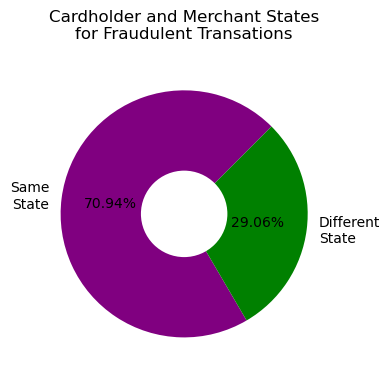

In [17]:
# Calculate the amount of fraud transactions with same state and different state.
isStateSame = clean_fraud_merchant_df["isStateSame"].value_counts()

# Create a donut chart
plt.figure(figsize=(4, 4))
plt.pie(isStateSame, labels=["Same\nState","Different\nState"], autopct='%1.2f%%', startangle=45, colors=["purple", "green"])
plt.axis('equal')
centre_circle = plt.Circle((0,0),0.35,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Cardholder and Merchant States\nfor Fraudulent Transations")
plt.tight_layout()
plt.savefig("Images/daniel-5.png")
plt.show()

In [18]:
# Create a Data Frame with the top three cardholder States and their amount fraudulent transactions
top = clean_fraud_merchant_df.groupby("state")["trans_num"].nunique().reset_index()
top = top.sort_values(by="trans_num", ascending=False).head(3)

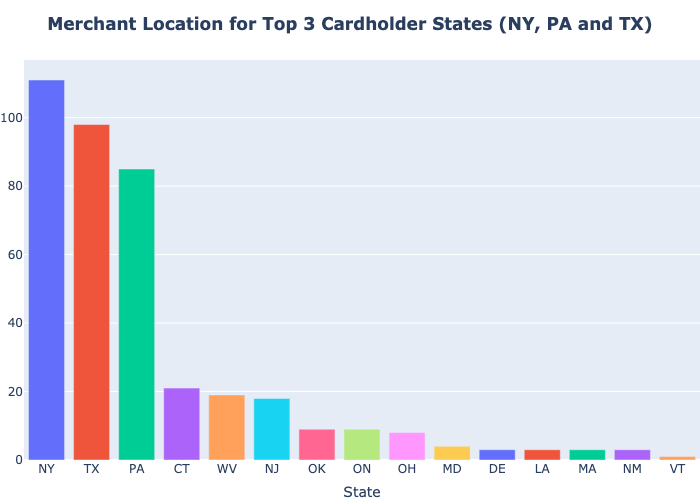

In [19]:
# Filter Data by the top three States and group by the merchant state
top_states = clean_fraud_merchant_df["state"].isin(top["state"])
top_states_df = clean_fraud_merchant_df[top_states][["merch_state","trans_num"]]
top_states_df = top_states_df.groupby("merch_state")["trans_num"].nunique().reset_index()
top_states_df = top_states_df.sort_values(by="trans_num", ascending=False)

# Create a bar chart with the merchant states
topbar = px.bar(top_states_df,
                x="merch_state",
                y="trans_num",
                title= "<b>Merchant Location for Top 3 Cardholder States (NY, PA and TX)",
                color="merch_state",
                category_orders={"merch_state":top_states_df["merch_state"]}
)
topbar.update_yaxes(title=None)
topbar.update_xaxes(title="State")
topbar.update_layout(showlegend=False,
                         title_font_size=17,
                         title_x=0.5,
                         margin = dict(l=0,
                                       r=0,
                                       b=10,
                                       t=60,
                                       autoexpand=True
                        )
)
topbar.write_image("Images/daniel-6.png")
display(Image('Images/daniel-6.png'))